# Neural Network (NN) pyTorch

### Цель работы - обучить нейронную сеть выполнять преобразование Фурье и спектральную плотность мощности подаваемого на вход сигнала.

Во всем проекте мы будем работать со входом из строк размером (длиной) 1024

## Часть 1. Фурье преобразование

### Подготовка данных

In [5]:
!pip3 install torch

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 66.5 MB 2.4 MB/s eta 0:00:01
  Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
     |████████████████████████████████| 134 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 184 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 2.6 MB/s eta 0:00:01
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from scipy import signal

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split

Сгенерируем и подготовим данные (сигнал) любым пакетом для численного преобразования Фурье, [например](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html#numpy.fft.fft)

In [7]:
num_signals = 10000
signal_length = 1024
num_freq = 5
sampling_rate = 1024

signals = []
spectra = []

# Генерим сигнал
for _ in range(num_signals):
  frequencies = np.random.uniform(1, sampling_rate // 2, num_freq)
  amplitudes = np.random.uniform(0.1, 1.0, num_freq)

  t = np.linspace(0, 1, signal_length, endpoint=False)

  real_signal = sum(amplitudes[i] * np.sin(2 * np.pi * frequencies[i] * t) for i in range(num_freq))
  real_signal = real_signal / np.max(np.abs(real_signal))

  # спектр сигнала (Фурье)
  fft_result = np.fft.fft(real_signal)
  amplitude_spectrum = np.abs(fft_result[:signal_length // 2])

  signals.append(real_signal)
  spectra.append(amplitude_spectrum)


signals_tensor = torch.tensor(signals, dtype=torch.float32)
spectra_tensor = torch.tensor(spectra, dtype=torch.float32)
dataset = TensorDataset(signals_tensor, spectra_tensor)

/var/folders/6c/9qg5_9f1765c3d0_5hwqsm6m0000gn/T/ipykernel_57147/3839370109.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  signals_tensor = torch.tensor(signals, dtype=torch.float32)


### Соберем и обучим нейросетку на pyTroch для преобразования Фурье

In [8]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Построение нейросети (выбор последовательности скрытых слоев взят из статьи по обучении нейронки для fast fourier transform (FFT))

In [9]:
class FFTApproximator(nn.Module):

  def __init__(self, input_size, output_size):
    super(FFTApproximator, self).__init__()
    
    self.fc1 = nn.Linear(input_size, 512)
    self.act1  = nn.ReLU()
    self.fc2 = nn.Linear(512, 256)
    self.act2  = nn.ReLU()
    self.fc3 = nn.Linear(256, output_size)

  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)

    return x

Обучение нейронной сети

In [10]:
input_size = signal_length
output_size = signal_length // 2

model = FFTApproximator(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in tqdm(range(epochs)):
  for batch_signals, batch_targets in train_loader:
    outputs = model(batch_signals)
    loss = criterion(outputs, batch_targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


### Сравним свое решение с пакетным методом

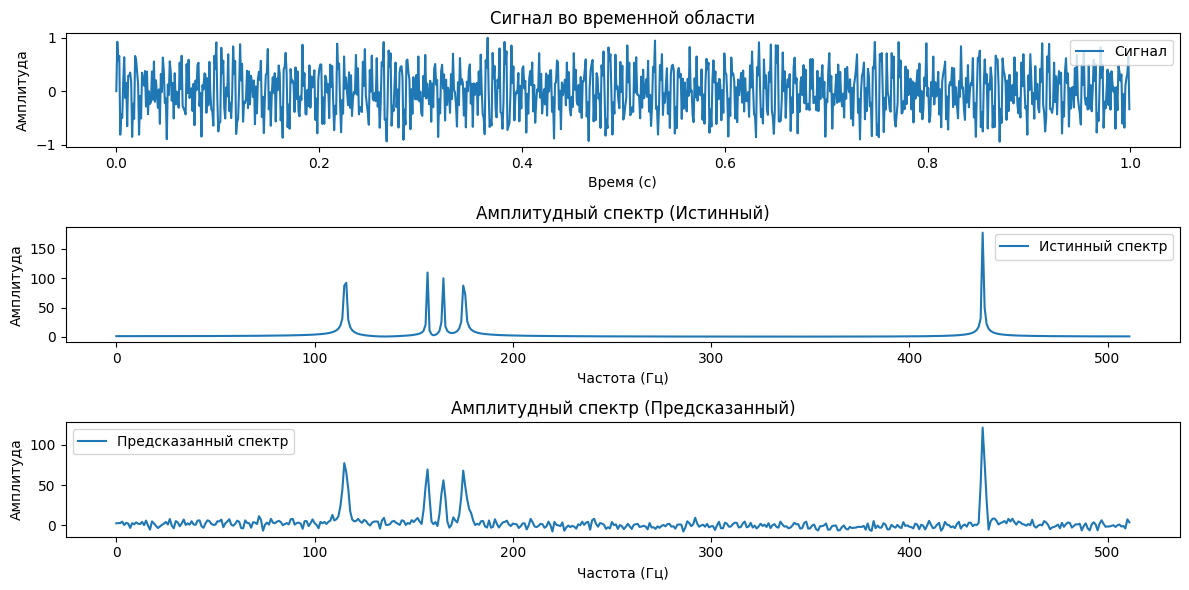

In [11]:
for batch_signals, batch_targets in test_loader:
  outputs = model(batch_signals)
  break
frequencies_fft = np.fft.fftfreq(signal_length, 1 / sampling_rate)[:signal_length // 2]

plt.figure(figsize=(12, 6))

# сигнал
plt.subplot(3, 1, 1)
plt.plot(t, batch_signals.squeeze().numpy()[0], label='Сигнал')
plt.title('Сигнал во временной области')
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда')
plt.legend()

# таргет
plt.subplot(3, 1, 2)
plt.plot(frequencies_fft, batch_targets.squeeze().numpy()[0], label='Истинный спектр')
plt.title('Амплитудный спектр (Истинный)')
plt.xlabel('Частота (Гц)')
plt.ylabel('Амплитуда')
plt.legend()

# предсказание
plt.subplot(3, 1, 3)
plt.plot(frequencies_fft, outputs.detach().numpy()[0], label='Предсказанный спектр')
plt.title('Амплитудный спектр (Предсказанный)')
plt.xlabel('Частота (Гц)')
plt.ylabel('Амплитуда')
plt.legend()

plt.tight_layout()
plt.show()

## Часть 2. Power spectral density (dB)

### Подготовка данных

Подготовим обучающую выборку используя пакетное решение, [например](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html)

### Замечание:
По теореме Винера-Хинчина спектральная плотнсть мощности это Фурье-образ автокоррелятора сигнала, 
так что это по сути предыдущая задача, только теперь нейронка будет учиться брать Фурье от автокоррелятора, а не от самого сигнала. 
Точнее сначала считать автокоррелятор, потом брать Фурье. 
Поэтому воспользуемся той же схемой нейронной сети, только добавив еще один скрытый слой, 
для того чтобы нейросеть научилась еще и определять зависимость в виде сигнал <-> автокоррелятор

Как и в примере из мануала добавлю шум к основному сигналу (так более реалистично)

In [12]:
rng = np.random.default_rng()
noise_power = 0.001 * sampling_rate / 2

num_freq = 1
frequencies = np.random.uniform(1, sampling_rate // 2, num_freq)
amplitudes = np.random.uniform(1.0, 10.0, num_freq)

t = np.linspace(0, 1, signal_length, endpoint=False)

real_signal = sum(amplitudes[i] * np.sin(2 * np.pi * frequencies[i] * t) for i in range(num_freq))
noise = rng.normal(scale=np.sqrt(noise_power), size=t.shape)
real_signal += noise
real_signal = real_signal / np.max(np.abs(real_signal))

f, Pxx_den = signal.periodogram(real_signal, sampling_rate)

Отобразим сгенерированную зашумленную спектральную плотность мощности (PSD)

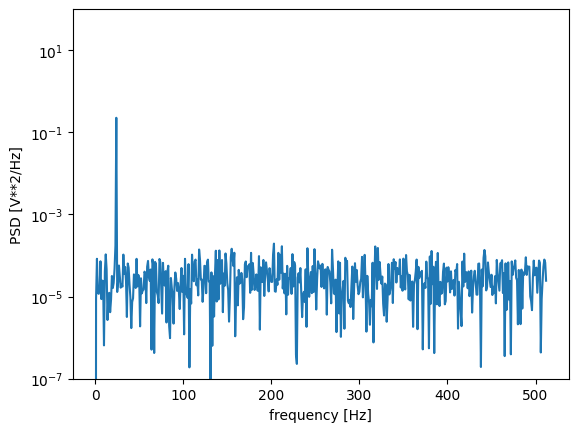

In [13]:
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

Сформируем датасет случайных гармоник (в интересующем нас диапазоне частот) со случайными амплитудами, и добавим к каждой из них случайный шум. Нейросеть будет учиться на данном датасете какой результат выдает ф-ия при каких гармониках, будет искать зависимость между входными данными и таргетом. Имея в качестве базиса в датасете набор таких гармоник, нейросеть должна будет научиться понимать какой будет результат, в случае если сигнал будет преставлять из себя набор гармоник. 

Примечание: это уже более сложная задача, поэтому для улучшения точности модели можно увеличить размер обучающей выборки из одиночных гармоник или расширить датасет сигналами, состоящими из нескольких гармоник

In [14]:
signals = []
PSDs = []

num_freq = 1
num_signals = 10000

# Генерируем сигнал
for _ in range(num_signals):
  frequencies = np.random.uniform(1, sampling_rate // 2, num_freq)
  amplitudes = np.random.uniform(1.0, 10.0, num_freq)

  t = np.linspace(0, 1, signal_length, endpoint=False)

  real_signal = sum(amplitudes[i] * np.sin(2 * np.pi * frequencies[i] * t) for i in range(num_freq))
  noise = rng.normal(scale=np.sqrt(noise_power), size=t.shape)
  real_signal += noise
  real_signal = real_signal / np.max(np.abs(real_signal))

  # спектральная плотность мощности
  _, Pxx_den = signal.periodogram(real_signal, sampling_rate)

  signals.append(real_signal)
  PSDs.append(Pxx_den[:-1])


print(np.array(PSDs).shape)
signals_tensor = torch.tensor(signals, dtype=torch.float32)
power_tensor = torch.tensor(PSDs, dtype=torch.float32)
dataset = TensorDataset(signals_tensor, power_tensor)

(10000, 512)


Поделим датасет на тренировочную и тестовую выборки

In [15]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Соберем и обучим нейросеть для предсказания спектральной плотности мощности

*Примечание: для входа 1024 выход будет 512*

Построение нейронной сети (выбор слоев обоснован в начале раздела)

In [16]:
class PSDApproximator(nn.Module):
  
  def __init__(self, input_size, output_size):
    super(PSDApproximator, self).__init__()
    
    self.fc1 = nn.Linear(input_size, 512)
    self.act1  = nn.ReLU()
    self.fc2 = nn.Linear(512, 512)
    self.act2  = nn.ReLU()
    self.fc3 = nn.Linear(512, 256)
    self.act3  = nn.ReLU()
    self.fc4 = nn.Linear(256, output_size)

  def forward(self, x):
    
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    x = self.act3(x)
    x = self.fc4(x)

    return x

Обучение NN

In [17]:
input_size = signal_length
output_size = signal_length // 2

print(input_size, output_size)

model = PSDApproximator(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in tqdm(range(epochs)):
  for batch_signals, batch_targets in train_loader:
    outputs = model(batch_signals)
    loss = criterion(outputs, batch_targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

1024 512


100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


### Провалидируем полученное решение и качественно оценим результаты

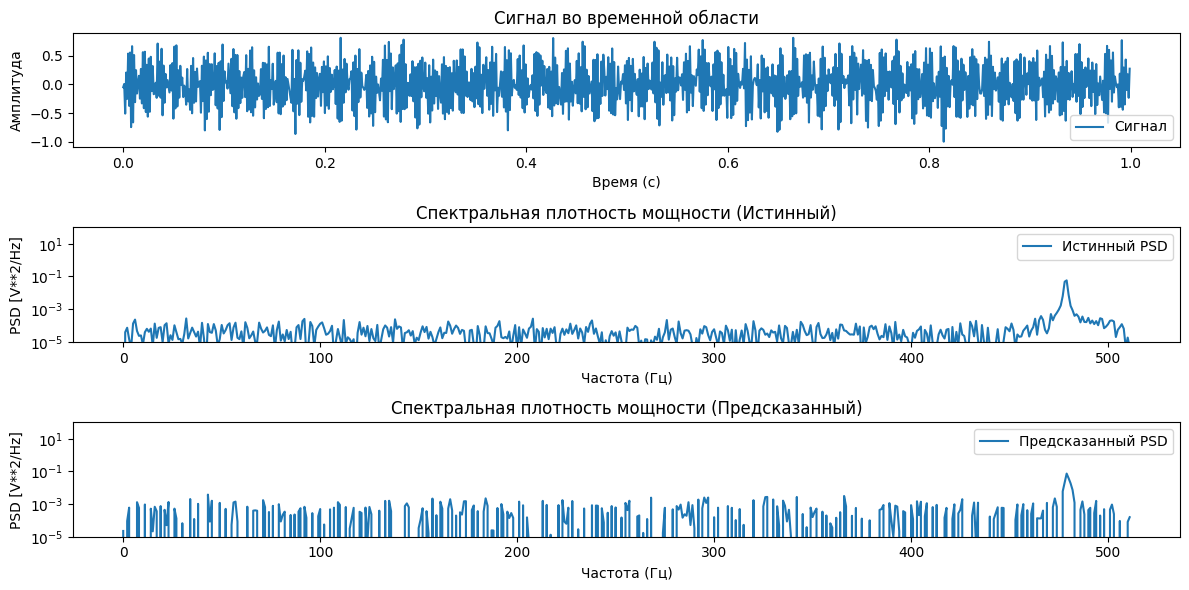

In [18]:
for batch_signals, batch_targets in test_loader:
  outputs = model(batch_signals)
  break
frequencies_fft = np.fft.fftfreq(signal_length, 1 / sampling_rate)[:signal_length // 2]

order_numer = 1

plt.figure(figsize=(12, 6))

# сигнал
plt.subplot(3, 1, 1)
plt.plot(t, batch_signals.squeeze().numpy()[order_numer], label='Сигнал')
plt.title('Сигнал во временной области')
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда')
plt.legend()

# таргет
plt.subplot(3, 1, 2)
plt.semilogy(frequencies_fft, batch_targets.squeeze().numpy()[order_numer], label='Истинный PSD')
plt.title('Спектральная плотность мощности (Истинный)')
plt.ylim([1e-5, 1e2])
plt.xlabel('Частота (Гц)')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()

# предсказание
plt.subplot(3, 1, 3)
plt.semilogy(frequencies_fft, outputs.detach().numpy()[order_numer], label='Предсказанный PSD')
plt.title('Спектральная плотность мощности (Предсказанный)')
plt.ylim([1e-5, 1e2])
plt.xlabel('Частота (Гц)')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()

plt.tight_layout()
plt.show()